<a href="https://colab.research.google.com/github/marcon21/anlp-labs/blob/main/03_ANLP_Measuring_Quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Start by copying this into your Google Drive!!

Maastricht_University_logo.svg

# Advanced Natural Language Processing Course - Tutorial Measuring Quality
Author: Gijs Wijngaard




Version 2024-2025.1


---



Welcome to the tutorial on measuring quality.


The first step is to **enable GPU**. A GPU is a Graphical Processing Unit, capable of calculating vectors and matrices much faster than CPU units, like the one in your laptop. Since neural networks are basically made out of matrices, we gain serious speed improvements by using GPU's.

We enable the GPU by clicking on *Runtime* in the menu above, then click *Change runtime type* and on the dropdown menu under *Hardware accelerator* we click *GPU*. Then click *Save*. If everything is correct, the below code should return *True*

---

## Measuring Output Quality of a Classification Model
We start with training a machine learning model first. We train a Transformers model on the most popular benchmark in natural language processing, named GLUE. This benchmark and its successor SuperGLUE are used in NLP research a lot to compare models to each other. Its a way for any model to test it if is performing well or not. You can find the benchmark [here](https://gluebenchmark.com/) and its [successor](https://super.gluebenchmark.com/) here. We are going to use one of its datasets as a task for our model to train on. Lets install some packages first:

In [2]:
!pip install -qq transformers datasets

GLUE consists of 11 datasets. Today, we will focus on only one of these, the Corpus of Linguistic Acceptability. This dataset is a dataset to test whether a model can recognize whether a sentence is actual English, or contains some spelling or grammatical mistakes. Lets import it:

In [3]:
from datasets import load_dataset
data = load_dataset("glue", "cola")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/35.3k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/251k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/37.6k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/37.7k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8551 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1043 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1063 [00:00<?, ? examples/s]

Lets display how our data looks like. This is a example of a correct sentence in our dataset (label = 1)

In [4]:
data["train"][0]

{'sentence': "Our friends won't buy this analysis, let alone the next one we propose.",
 'label': 1,
 'idx': 0}

Hereunder is an example of an incorrect sentence in our dataset (label = 0). You can't drink a pub right? That is for the model to recognize, can it find sentences that are incorrect.

In [6]:
data["train"][18]

{'sentence': 'They drank the pub.', 'label': 0, 'idx': 18}

Lets now import our model. This is the first time we work with transformers models. Transformers is a library by HuggingFace. When working with transformer-based models, its one of the most convenient tools you can have. It supports all types of different trasnformer models, and you can download pretrained models from the transformers library to apply it to your own data. Normally, transformer models work well when trained on large datasets. With pretrained models, these models are already trained on large datasets thus do not need to be trained again. Its handy for applying state-of-the-art models on any problem you have.

Let's use the most standard transformer model, that of BERT. We can use BERT for a variety of tasks, this time we will use it for sequence classification.  In a later lecture you will learn more about BERT and its applications. For our task, we want to know whether our data (which is a sequence) is a right english sentence or not (binary classification task).
We also use `.to(device)` method to speed things up. If you don't want to wait long when predicting outputs using transformers, make sure you are on GPU in colab.

You can ignore the warnings starting with `Some weights ...`, their just for letting you know what you can do with the model.

In [7]:
from sklearn import metrics
from tqdm import tqdm
import numpy as np
import torch
from transformers import BertTokenizer, BertForSequenceClassification
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased").to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Lets train our model first. We first define a dataloader. This function is used so that we can have large batches (`batch_size=16` in this case) and process multiple data inputs at once. This even speeds up the computation more. We first nullify our gradients. We put the data through the tokenizer, so that we get numbers instead of texts. Also an `attention_mask` is received from our tokenizer, so that our transformer model knows which part of the data to focus on: we pad the data to let it fit through the model. As model input, we feed the output of the tokenizer and a label, so that the model can compute a loss that defines how close we are to the label. We then backpropagate.

In [8]:
losses = []
train_dataloader = torch.utils.data.DataLoader(data["train"], batch_size=16)
for item in tqdm(train_dataloader):
    model.zero_grad()
    inputs = tokenizer(item["sentence"], padding=True, return_tensors="pt").to(device)
    result = model(**inputs, labels=item["label"].to(device))
    loss = result.loss
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

100%|██████████| 535/535 [00:45<00:00, 11.71it/s]


Lets now define a simple prediction function. Remember, always train on a training set, and test your model on a validation set.

We don't want to compute gradients, since we will not backpropagate the data (`torch.no_grad()`). We get the logits and move that onto the cpu with `.cpu().numpy()`.

In [9]:
val_dataloader = torch.utils.data.DataLoader(data["validation"], batch_size=16)
results = []
for item in tqdm(val_dataloader):
    inputs = tokenizer(item["sentence"], padding=True, return_tensors="pt").to(device)
    with torch.no_grad():
        logits = model(**inputs).logits
    results.append(logits.argmax(dim=-1).cpu().numpy())
results = [result for result_array in results for result in result_array]

100%|██████████| 66/66 [00:01<00:00, 45.83it/s]


These are our true values: The actual correct values of the validation set

In [10]:
val_labels = [data["label"] for data in data["validation"]]

We again can use the `accuracy_score` function from `scikit-learn`. This function predicts for us the `accuracy`: how many true positives and true negatives devided by all predictions we have.

In [11]:
metrics.accuracy_score(val_labels, results)

0.7823585810162992

We also can plot a confusion matrix with `scikit-learn`. These values correspond to each of the 4 sectors. True positives,  true negatives, false positives, false negatives.

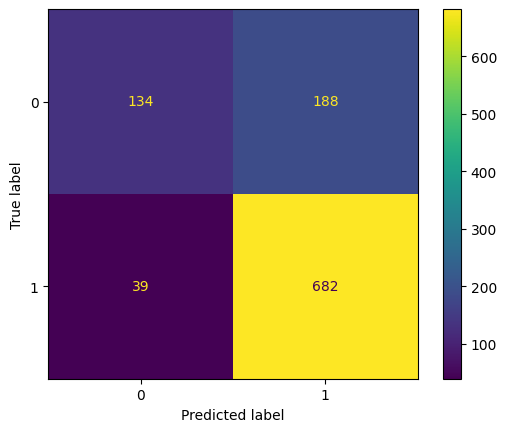

In [12]:
metrics.ConfusionMatrixDisplay.from_predictions(val_labels, results)

We can get the individual values using sklearn's `confusion_matrix`:

In [13]:
tn, fp, fn, tp = metrics.confusion_matrix(val_labels, results).ravel()
tn

134

In [14]:
fn

39

### Exercise 1.1
> 1. Compute the following metrics by hand: $$Precision = \frac{TP}{TP+FP}\quad Recall = \frac{TP}{(TP+FN)} \quad Accuracy = \frac{TP + TN}{TP + TN + FP + FN} \quad F1 = 2 * \frac{Precision * Recall}{Precision + Recall}$$ using the variables `tn`, `fp`, `fn`, `tp` above.
2. Why is `accuracy` not a good metric for this dataset?

In [21]:
# COMPUTE PRECISION, RECALL, ACCURACY AND F1 HERE

precision = tp / (tp + fp)
recall = tp / (tp + fn)
accuracy = (tp + tn) / (tp + tn + fp + fn)
f1 = 2 * (precision * recall) / (precision + recall)

precision, recall, accuracy, f1

(0.7839080459770115,
 0.9459084604715673,
 0.7823585810162992,
 0.8573224387177876)

ANSWER HERE:

1.1.2: Accuracy is usually not the best metric for imbalanced datasets, like in this case. A better option could be to use the other metrics calculated or AOC

### Exercise 1.2
> 1. When do we prefer precision?
2. When do we prefer recall?
3. Give an examples of datasets that you could encounter where you would prefer one over the other.

ANSWER HERE:

1.2.1: When we want to minimize false positives.

1.2.2: When we want to minimize false negatives

1.2.3: Precision could be better suited to evaluate when to lend loans to people, where you want to minimize the risk of not getting payed back. Recall could be prefered in the context of analyzing the food safety during the manufactoring process, where you want to avoid to give potentially harmful food to the end user.



### Exercise 1.3
> 1. Now also compute $F0.5$ and $F2$ metrics.
2. How do these compare to the $F1$ metric?

ANSWER HERE

In [22]:
# COMPUTE F0.5 and F2 metrics here
f05 = (1.25 * precision * recall) / (0.25 * precision + recall)
f2 = (5 * precision * recall) / (4 * precision + recall)

f05, f1, f2

(0.8117114972625564, 0.8573224387177876, 0.9083644112946191)

1.3.2: While f1 takes into account in an equal way precision and recall, f05 gives a result skewed to maximize precision while f2 gives more priority to miximizing recall

### Exercise 1.4
> Instead of using `accuracy`, the GLUE benchmark uses a different metric for this dataset, Matthews correlation coefficient (also known as the Phi coefficient). $$MCC = \frac{TP \times TN - FP\times FN}{\sqrt{(TP+FP)\times(TP+FN)\times(TN+FP)\times(TN+FN)}}$$ When computing this coefficient, we should get a value between 1 and -1, where 1 is a perfect prediction, 0 a random prediction and -1 a inverse prediction. Now compute also the MCC:

In [23]:
# COMPUTE MCC HERE
mcc = (tp * tn - fp * fn) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

mcc

0.4496664370323995


## Using Model's probabilities
We now computed some metrics using the predictions of the model: whether the model thinks its correct or incorrect. To calculate this, we took the `argmax()` of the logits. Let's focus one more time on what we did.

In [24]:
inputs = tokenizer(next(iter(val_dataloader))["sentence"], padding=True, return_tensors="pt").to(device)
with torch.no_grad():
    logits = model(**inputs).logits
logits = logits.cpu().detach()

We used these logits and for every pair of two we took whatever value is the highest (`argmax()`). Now we can also take the softmax, this then converts our values to make them sum together to 1 per prediction:

In [25]:
logits.softmax(dim=-1)

tensor([[0.0407, 0.9593],
        [0.0427, 0.9573],
        [0.0512, 0.9488],
        [0.0790, 0.9210],
        [0.1980, 0.8020],
        [0.0815, 0.9185],
        [0.1630, 0.8370],
        [0.1891, 0.8109],
        [0.0917, 0.9083],
        [0.0813, 0.9187],
        [0.1077, 0.8923],
        [0.1957, 0.8043],
        [0.0538, 0.9462],
        [0.6672, 0.3328],
        [0.0658, 0.9342],
        [0.2634, 0.7366]])

As you can see, we now have a percentage per prediction of how sure the model is about that prediction, the the first value being the sentence is incorrect, the second value the sentence being correct. Lets now only take the last value of each prediction: we only need the chance that a value belongs to 1, if its higher than 50% probability it belongs so, if lower, it belongs to 0.

In [26]:
percentage = logits.softmax(dim=-1)[:, -1]

In [27]:
percentage

tensor([0.9593, 0.9573, 0.9488, 0.9210, 0.8020, 0.9185, 0.8370, 0.8109, 0.9083,
        0.9187, 0.8923, 0.8043, 0.9462, 0.3328, 0.9342, 0.7366])

Lets collect the percentages for the whole validation dataset, and plot the precision-recall curve:

In [28]:
percentages = []
for item in tqdm(val_dataloader):
    inputs = tokenizer(item["sentence"], padding=True, return_tensors="pt").to(device)
    with torch.no_grad():
        logits = model(**inputs).logits
    percentages.append(logits.softmax(dim=-1)[:, -1].cpu().numpy())
percentages = np.array([result for result_array in percentages for result in result_array])

100%|██████████| 66/66 [00:01<00:00, 40.93it/s]


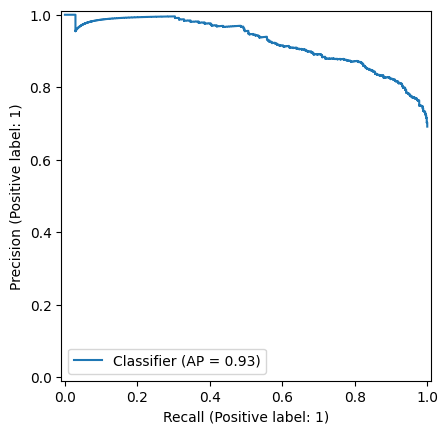

In [29]:
from sklearn.metrics import PrecisionRecallDisplay
import matplotlib.pyplot as plt
PrecisionRecallDisplay.from_predictions(val_labels, percentages)

Lets go over how this graph is calculated. On each step in the graph, we change the probability boundary, to get a different precision and recall value (also can be applied to TPR and FPR in ROC/AUC graphs) For example, normally we would just take 50% as boundary. All values that are above 0.5 are counted as being 1, all values below 0.5 are counted to 0. So these indices are predicted as false:

In [30]:
np.where(percentages < 0.5)

(array([  13,   23,   32,   41,   44,   45,   60,   65,   73,   74,   77,
          80,   86,   91,  101,  114,  129,  140,  146,  155,  165,  169,
         170,  175,  178,  191,  192,  194,  196,  201,  202,  212,  220,
         224,  225,  226,  229,  236,  246,  252,  255,  257,  269,  270,
         271,  274,  278,  281,  327,  329,  332,  335,  338,  342,  344,
         353,  354,  362,  365,  372,  384,  386,  387,  391,  392,  398,
         399,  407,  408,  415,  428,  432,  437,  450,  451,  453,  455,
         457,  458,  459,  460,  469,  471,  472,  475,  478,  494,  496,
         497,  500,  501,  504,  507,  509,  519,  521,  522,  544,  579,
         580,  604,  613,  614,  618,  622,  624,  625,  630,  644,  646,
         654,  676,  692,  693,  695,  700,  702,  707,  720,  728,  729,
         730,  731,  740,  751,  785,  787,  788,  807,  809,  810,  812,
         813,  818,  819,  823,  832,  836,  839,  840,  852,  868,  877,
         887,  889,  890,  907,  911, 

In [31]:
indices = np.where(percentages < 0.5, 0, 1)
print(metrics.precision_score(val_labels, indices))
print(metrics.recall_score(val_labels, indices))

0.7839080459770115
0.9459084604715673


Notice that this decision boundary is set to 0.5 with `np.where()`, we can change that to 0.9 or 0.4 or anything else.

In [32]:
indices = np.where(percentages < 0.8, 0, 1)
print(metrics.precision_score(val_labels, indices))
print(metrics.recall_score(val_labels, indices))

0.8472222222222222
0.8460471567267683


With the default 0.5 decision boundary, we get a somewhat high `precision`, but our `recall` is still low. Sometimes, we want one over the other, thus it makes sense to change the decision boundary. Say when you want to model to be absolutely sure about its predictions, you could then state that you only allow prediction values higher than 0.9 to be accepted (as 1) and the rest is 0.

Lets compute the values for this precision recall curve, we can also get the thresholds for this curve, so we know at which values the precision and recall was calculated (remember the threshold is our boundary). The amount of threshold values is equal to the number of unique percentages we have calculated from our dataset, e.g. `len(np.unique(percentages))`. By default we calculate the precision and recall for these thresholds, when calculating them for the graph above:

In [33]:
precision, recall, thresholds = metrics.precision_recall_curve(val_labels, percentages)
thresholds

array([0.16590786, 0.16754225, 0.17050199, ..., 0.96588236, 0.9660099 ,
       0.96639854], dtype=float32)

### Exercise 2: 11-points Precision Recall
Let's make an averaged 11-point precision recall graph (similar to the precision recall graph above, but now with only 11 points) , as explained in the lecture, and plot this below. For a refresher, [check here](https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-ranked-retrieval-results-1.html). You can use the [precision](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html) and [recall](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html) functions from scikit-learn.

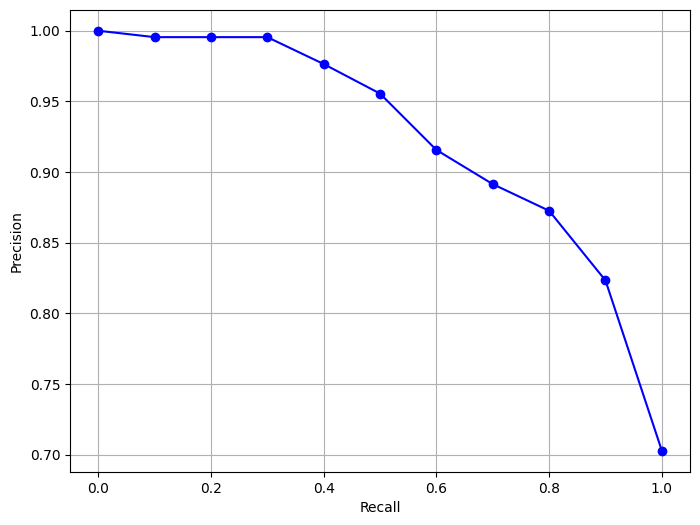

In [39]:
precision, recall, thresholds = metrics.precision_recall_curve(val_labels, percentages)

recall_levels = np.linspace(0.0, 1.0, 11)

precision_at_recall_levels = []
for level in recall_levels:
    max_precision = max(precision[recall >= level]) if np.any(recall >= level) else 0
    precision_at_recall_levels.append(max_precision)

plt.figure(figsize=(8, 6))
plt.plot(recall_levels, precision_at_recall_levels, marker='o', color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

## Metrics in Machine Translation

We now continue to work with machine translation models. We again work with `transformers` pretrained models. This time we work on a translation dataset, that from news articles that are from 2 languages. We ask the model to translate from Dutch to English, and then we test how good the model performs. Don't worry if you don't know Dutch! You do not need to.

Lets import the model first and split the data up in training and test sets.

In [40]:
from datasets import load_dataset

dataset = load_dataset("opus_books", "en-nl")
dataset = dataset["train"].train_test_split(test_size=0.2)

README.md:   0%|          | 0.00/28.1k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.44M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/38652 [00:00<?, ? examples/s]

Lets check our dataset.

In [41]:
dataset["train"][0]["translation"]

{'en': 'But how long would it take to navigate under the Ice Bank to the open sea?',
 'nl': 'Maar hoelang zou die vaart onder de ijsbank nog duren?'}

Alright, lets import an encoder-decoder model. In a later Colab in Course 8 of Advanced Natural Language Processing you will also work on Machine Translation, now we just want you to focus on computing the metrics for these notebooks, namely BLEU and METEOR.

Down here we define a encoder-decoder model `t5-small`. We preprocess the input of these models so that it has a prompt, we can steer the model to come up with a solution then. We tokenize the input, truncate texts that are longer than 256 tokens, and batch them.

In [42]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq
tokenizer = AutoTokenizer.from_pretrained("t5-small")
model = AutoModelForSeq2SeqLM.from_pretrained("t5-small").to(device)
prefix = "translate Dutch to English: "
def preprocess_function(examples):
    inputs = [prefix + example["nl"] for example in examples["translation"]]
    targets = [example["en"] for example in examples["translation"]]
    return tokenizer(inputs, text_target=targets, max_length=256, truncation=True)
train_data = dataset["train"].map(preprocess_function, batched=True, remove_columns=["id", "translation"])
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Map:   0%|          | 0/30921 [00:00<?, ? examples/s]

We put the data in a dataloader, which allows us for faster processing, we define an optimizer to train our model. The following code, for 1 epoch, takes about 10 minutes to train. Please make sure you are on a GPU (check instructions at the beginning of this notebook), else it will take longer!

In [43]:
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=32, collate_fn=data_collator)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

for epoch in range(1):
    for item in tqdm(train_dataloader):
        model.zero_grad()
        loss = model.forward(**item.to(device)).loss
        loss.backward()
        optimizer.step()

100%|██████████| 967/967 [09:50<00:00,  1.64it/s]


We now take the test dataset and do exactly the same, this time we ask the model to come up with the english string he thinks is the translation of the dutch string.

In [44]:
def preprocess_test_function(examples):
    return tokenizer([prefix + example["nl"] for example in examples["translation"]], max_length=256, truncation=True)
test_data = dataset["test"].map(preprocess_test_function, batched=True, remove_columns=["id", "translation"])
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=32, collate_fn=data_collator)

Map:   0%|          | 0/7731 [00:00<?, ? examples/s]

We let the model generate the english strings and then decode the output tokens back to strings with `batch_decode()`, we skip special tokens in this decoding process that are needed for generation.

In [45]:
outputs = []
for item in tqdm(test_dataloader):
    output = model.generate(**item.to(device))
    outputs.append(output)
translation_results = tokenizer.batch_decode([x for y in outputs for x in y], skip_special_tokens=True)

  0%|          | 0/242 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|██████████| 242/242 [01:18<00:00,  3.09it/s]


Lets see what the results looks like!

In [46]:
translation_results[:5]

['"What\'s the difference between me and me?"',
 'Ook liet, in the midst of a culpa, he',
 '"What do you think, if you\'re a...?"',
 '"Oh, kerkhof!"',
 '"It was a savage savage."']

And now lets see what the original sentences look like (the ones the model should come close to when predicting):

In [47]:
references = [data["translation"]["en"] for data in dataset["test"]]
references[:5]

['"But he told you that he loved you."',
 'Then she cried, "Ahem!" under cover of the MEA CULPA, striking her breast so vigorously that everybody, even the lady with the red cushion, turned round toward her. Porthos paid no attention. Nevertheless, he understood it all, but was deaf.',
 'Who art thou that--that--"',
 '"In the graveyard!"',
 '"And the queen believes--"']

Hmm, It looks like its far of, but some words are there at least. Now, how do we know for sure the model is performing correctly/incorrectly? We need a metric!

## Bilingual Evaluation Understudy (BLEU)
BLEU is a good way to test how good these models perform. Normally you would just import a bleu metric from packages such as `NLTK` or `torchtext` and calcuate the score, but we are going to do it by hand (fun!). Lets implement $BLEU_1$, which means we focus ourselves on only unigrams (single words) (BLEU 1 is the BLEU score for n-grams where n = 1, so the UNIGRAMS. It look for single characters, not bi or trigrams). There is no need to include the more complex brevity penalties or other complex variation on the default BLEU-1.

Our candidate sentences are defined in `results`. Our reference sentences are defined in `references`.

We iterate over the results and references, and compute on each iteration for both result and reference the ngrams. We do this by counting the words/tokens in the sentence.


### Exercise 3: BLEU
> 1. Implement the BLEU score yourself, by using the formulas from [wikipedia](https://en.wikipedia.org/wiki/BLEU) or the slides.
2. Apply the BLEU score on one of the references and candidates to see if your implementation works.


In [49]:
# WRITE BLEU SCORE HERE
def blue_score(reference, prediction):
  reference_tokens = reference.split()
  prediction_tokens = prediction.split()

  reference_count = {}
  for word in reference_tokens:
    if word in reference_count:
      reference_count[word] += 1
    else:
      reference_count[word] = 1

  candidate_count = {}
  for word in prediction_tokens:
    if word in candidate_count:
      candidate_count[word] += 1
    else:
      candidate_count[word] = 1

  overlap = 0
  for word in candidate_count:
    if word in reference_count:
      overlap += min(candidate_count[word], reference_count[word])

  # Calculate precision (number of matches / total candidate unigrams)
  precision = overlap / len(prediction_tokens) if len(prediction_tokens) > 0 else 0

  return precision


In [56]:
for i in range(0, 10):
  s = blue_score(references[i], translation_results[i])
  print("Original: ", references[i])
  print("Translation: ", translation_results[i])
  print("BLEU Score:", s)
  print()

Original:  "But he told you that he loved you."
Translation:  "What's the difference between me and me?"
BLEU Score: 0.0

Original:  Then she cried, "Ahem!" under cover of the MEA CULPA, striking her breast so vigorously that everybody, even the lady with the red cushion, turned round toward her. Porthos paid no attention. Nevertheless, he understood it all, but was deaf.
Translation:  Ook liet, in the midst of a culpa, he
BLEU Score: 0.3333333333333333

Original:  Who art thou that--that--"
Translation:  "What do you think, if you're a...?"
BLEU Score: 0.0

Original:  "In the graveyard!"
Translation:  "Oh, kerkhof!"
BLEU Score: 0.0

Original:  "And the queen believes--"
Translation:  "It was a savage savage."
BLEU Score: 0.0

Original:  There was, to be sure, Father Joseph, but his name was never pronounced but with a subdued voice, such was the terror inspired by his Gray Eminence, as the cardinal’s familiar was called.
Translation:  "I was, we were, no matter what, Josef, who was a 

## Language Model Evaluation

We can also know how good our model performs by calculating the perplexity. For an encoder-decoder model, the model is trained on a cross entropy loss, so we just do:

In [57]:
perplexity = torch.exp(loss)
perplexity.item()

32.05377197265625

### Exercise 4: Perplexity
> 1. Research what perplexity is, and if our score above is good or not.
2. Are there also other metrics or ways how we can measure language models?

ANSWER HERE:

4.1: Perplexity measures how likely was the model to generate the correct work, where 1 indicates a perfect score, and higher values indicate more uncertainty. 32 is not a great score, but still quite decent indicating that the model is at least going in the right direction.


4.2: Yes, like the BLEU score we just saw, f1, accuracy and many other methods.




#Submission
Please share your Colab notebook by clicking File on the top-left corner. Click under Download on Download .ipynb and upload that file to Canvas.